<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import uuid
!pip install uuid
import json
!pip install lief==0.11.5
import lief
import pandas as pd
from pprint import pprint
import os
from IPython.display import HTML

### Preprocessing :
---
At this stage we will preprocess the raw data which represented as Mach-O file format.
Since both classes contain binary files, we will use a library that handles those files called `LIEF`. You can found the documentation [here](https://lief-project.github.io/doc/stable/api/python/macho.html) .



>### Mach-O file as JSON object :
The parsing result of each file is converted into a JSON object which is much easier to deal with to extract the relevant features from each file , As a result, each JSON file will look like this :




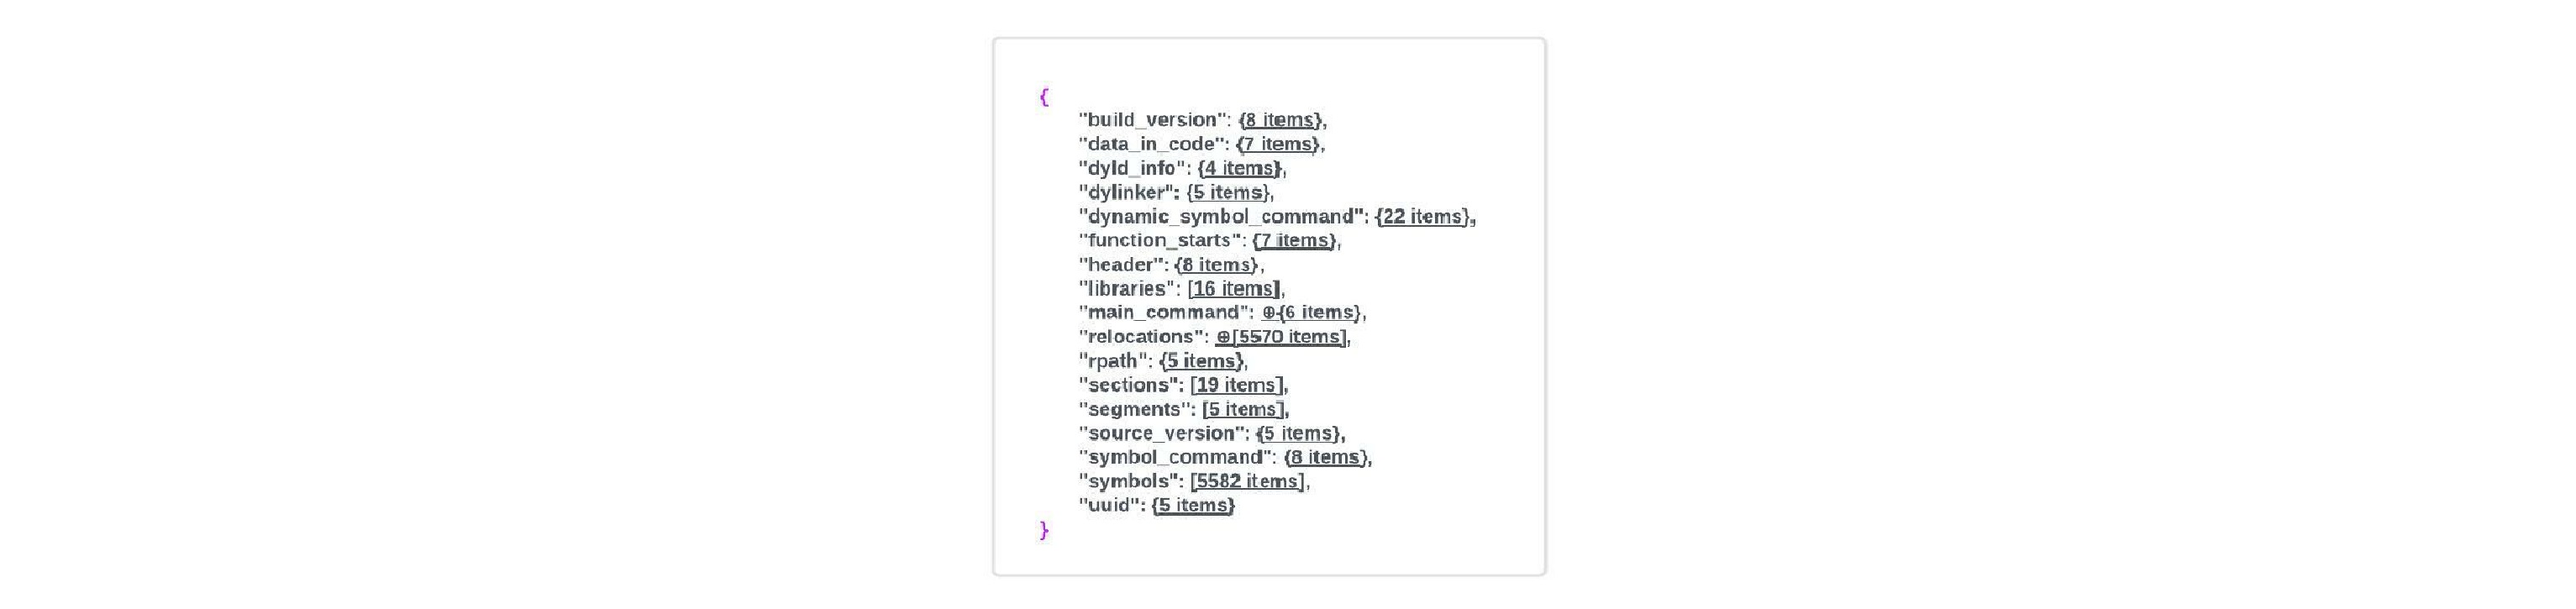

In [2]:
def get_raw_dataset(dataset_type):
  directory = '/content/drive/MyDrive/MacOSMalware/' + dataset_type
  # Create a raw data set that will contain records describing Mach-O files as JSON objects.
  dataset = pd.DataFrame()
  for filename in os.listdir(directory):
      macho_file = os.path.join(directory, filename)
      binary = lief.parse(macho_file)
      binary_json = json.loads(lief.to_json(binary))
      row = pd.Series(binary_json)
      dataset = dataset.append(row , ignore_index = True)
  return dataset

In [ ]:
raw_benign = get_raw_dataset("Benigns")
raw_malware = get_raw_dataset("Malwares")

# Since parsing takes quite a long time, we will keep the raw data sets for now.
raw_benign.to_csv("/content/drive/MyDrive/MacOSMalware/raw_benign.csv")
raw_malware.to_csv("/content/drive/MyDrive/MacOSMalware/raw_malwares.csv")

In [ ]:
raw_benign = pd.read_csv("/content/drive/MyDrive/MacOSMalware/raw_benign.csv" , index_col = 0)
raw_malware = pd.read_csv("/content/drive/MyDrive/MacOSMalware/raw_malwares.csv" , index_col = 0)
# check the dimension of the raw datasets
print(f'raw benign dataset shape : {raw_benign.shape} , raw malaware dataset shape : {raw_malware.shape}')

raw benign dataset shape : (101, 20) , raw malaware dataset shape : (106, 21)


In [ ]:
# Delete columns containing either 50% or more than 50% NaN Values
def delete_sparse_columns(raw_dataset):
  for column in raw_dataset:
      if sum(raw_dataset[column].isnull()) >= 50:
          raw_dataset.drop(column, axis=1, inplace = True) 

In [ ]:
delete_sparse_columns(raw_benign)
delete_sparse_columns(raw_malware)

# Since the two of the raw datasets have several different columns, we must ensure that they will have the same columns. 
same_columns = raw_benign.columns.intersection(raw_malware.columns).tolist()
raw_benign = raw_benign[same_columns]
raw_malware = raw_malware[same_columns]
print(f'raw benign dataset shape : {raw_benign.shape} , raw malaware dataset shape : {raw_malware.shape}')

raw benign dataset shape : (101, 16) , raw malaware dataset shape : (106, 16)


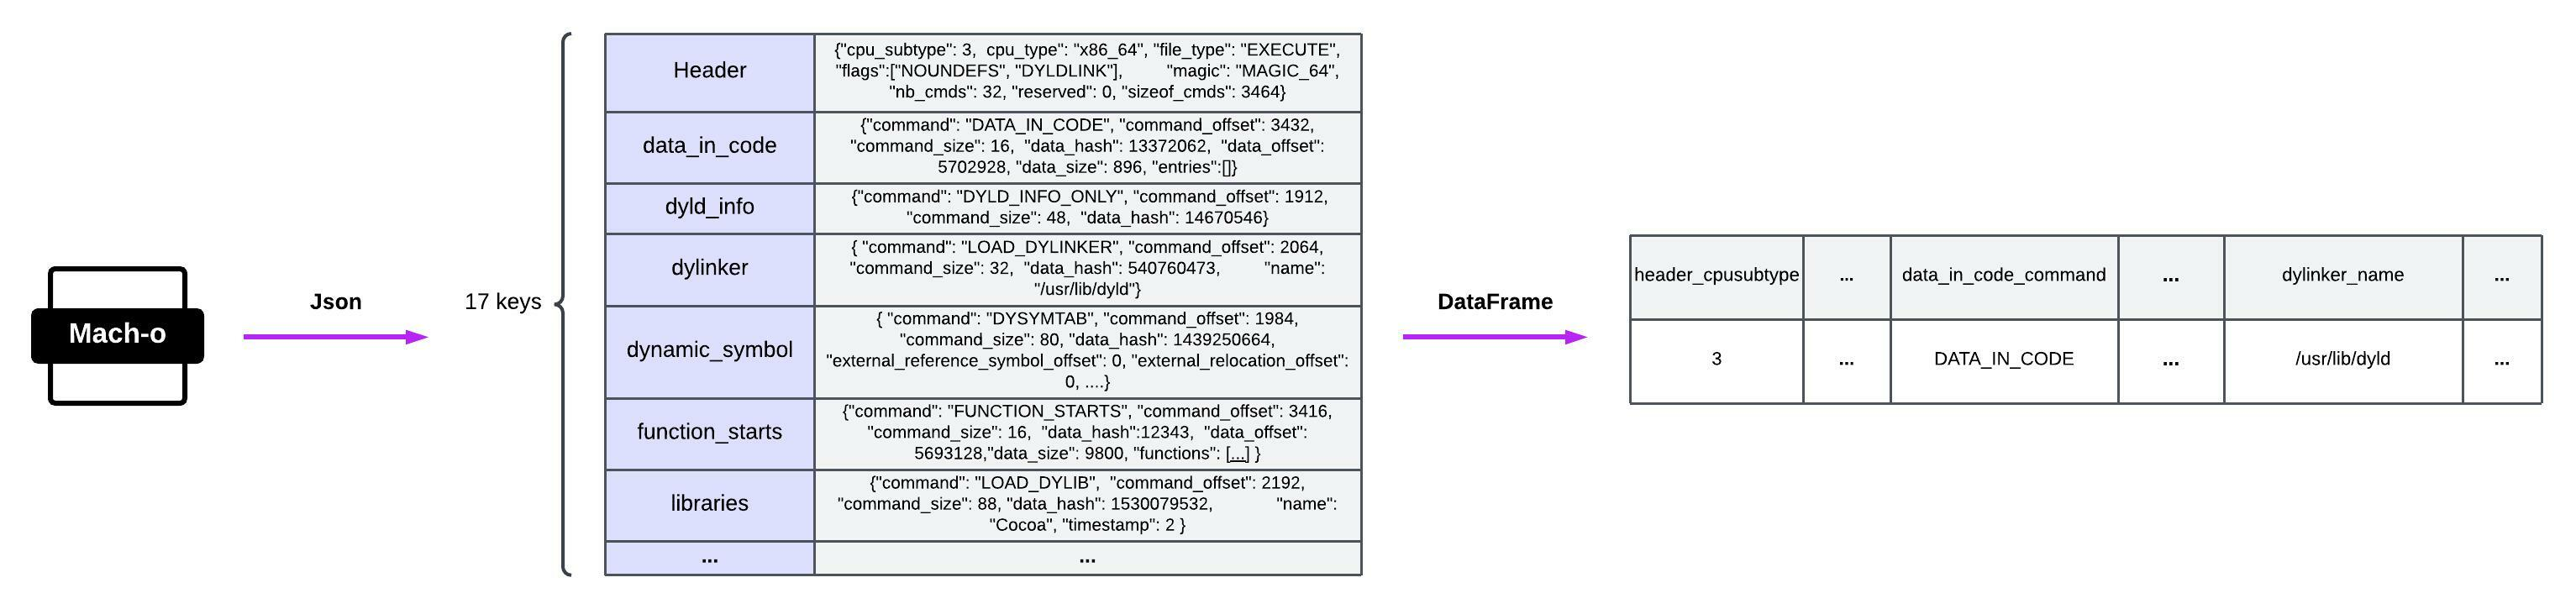

In [ ]:
# this library take an string and convert it to the original object that string represent such as list , dict , etc.
import ast

def extract_raw_features(raw_dataset , column):

  raw_features = {}
  for index , value in raw_dataset[column].items():
    
    value = str(value)
    
    if value == "nan":
      raw_features[index] = value # Nan

    else :
      value_type = ast.literal_eval(value)  
    
      if isinstance(value_type , dict):
          raw_features[index] = value_type
      
      elif isinstance(value_type , list):
            if column == 'libraries': # extract the name of the libraries which the file use
                libraries_names = []
                for lib in value_type:
                  libraries_names.append(lib['name'])
                raw_features[index] = libraries_names

            if column == 'sections': # extract the size of all the sections in the file
              sections_size = 0
              for section in value_type:
                  sections_size = sections_size + section['size']
              raw_features[index] = sections_size

            if column == 'segments': # extract information about the protection level for each segment in the file.
              segments = {}
              for segment in value_type:
                  segments[segment['name']] = {'init_protection' : segment['init_protection'] , 'max_protection': segment['max_protection']}
              raw_features[index] = segments

            if column == 'relocations': # extract the number of relocations that are present in that file
              raw_features[index] = len(value_type)

            if column == 'symbols': # extract the name of the symbol in the symbol table.
                symbols_names = []
                for symbol in value_type:
                  symbols_names.append(symbol['name'])
                raw_features[index] = symbols_names
                      

  if column == 'libraries' or column == 'symbols':
    raw_features =  pd.DataFrame([raw_features]).T
    raw_features.columns = [column + "_" + "names"]
    # create a new column in the dataframe , which represent the amount of the libraries or symbols in each record
    raw_features[column + '_length'] = raw_features[column + "_" + "names"].apply(lambda x: len(x))

  elif column == 'relocations' or column == 'sections':
    raw_features =  pd.DataFrame(raw_features , index = [0]).T
    raw_features.columns = [column + "_" + "size"]
    
  else:
    raw_features =  pd.DataFrame(raw_features).T  
    raw_features.columns = [column + "_" + col for col in raw_features.columns]

  return raw_features

In [ ]:
def get_extracted_features(raw_dataset) :
  extracted_features = []
  for column in raw_dataset.columns:
    extracted_features.append(extract_raw_features(raw_dataset , column))

  concatenated = pd.concat(extracted_features, axis="columns")
  concatenated = concatenated.applymap(str)

  for column in concatenated.columns[concatenated.isna().any()].tolist():
      concatenated[column] = concatenated[column].fillna('None')

  return concatenated

In [ ]:
benign_dataset = get_extracted_features(raw_benign)
# add the label for the benign dataset
benign_dataset['label'] = 0

In [ ]:
malware_dataset = get_extracted_features(raw_malware)
# add the label for the malware dataset
malware_dataset['label'] = 1

In [ ]:
import numpy as np
import plotly.express as px
def feature_distribution_plot(raw_dataset):
  # Iterate through the data set and check for each column what types it contains and their quantities.
  features , unique_values = ([],[])
  same_value_features = []
  for (col_name,col_value) in raw_dataset.iteritems():
          features.append(col_name)
          unique_values.append(len(np.unique(col_value)))
          if(unique_values[-1] == 1):
            # add the columns that contains one value for each record in the dataset
            same_value_features.append(col_name)

  df = pd.DataFrame(dict(zip(features, unique_values)) , index = ['amount']).T.reset_index()

  fig = px.bar(df, x='index', y='amount')
  fig.update_layout(bargap=0.2)
  fig.show()

In [ ]:
feature_distribution_plot(benign_dataset)

In [ ]:
feature_distribution_plot(malware_dataset)

Now, the data set contains values whose type is object, even if they represent some number.
Therefore we will convert those columns which describe numerical values to their appropriate type.

In [ ]:
def columns_to_numeric(dataset):
  #convert all the elements in the dataset to numeric, if it is not possible to convert an element to a numeric, it will be converted to NaN.
  numeric = dataset.apply(pd.to_numeric, errors='coerce')
  columns = numeric.columns[numeric.isna().sum() < dataset.shape[0]].tolist()

  #after we got the columns that can be a numeric , we convert them in the input dataset.
  dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')
  return dataset

In [ ]:
benign_dataset = columns_to_numeric(benign_dataset)
malware_dataset = columns_to_numeric(malware_dataset)

In [ ]:
common_columns = set(malware_dataset.columns).intersection(benign_dataset.columns)
benign_dataset = benign_dataset[common_columns]
malware_dataset = malware_dataset[common_columns]

dataset = pd.concat([benign_dataset, malware_dataset])
dataset.to_csv("/content/drive/MyDrive/MacOSMalware/dataset.csv")
dataset = pd.read_csv("/content/drive/MyDrive/MacOSMalware/dataset.csv" , index_col = 0)


### Dealing with categorical features

---
In this part we will transform those columns that contain categorical values using different methods.

In [ ]:
# Selecting the columns containing objects after performing the transformation.
object_columns = dataset.columns[dataset.dtypes == object]
complex_columns = set()

for column in object_columns:
    for value in dataset[column]:
      try:
        value_type = ast.literal_eval(value)  
        if isinstance(value_type , list) or isinstance(value_type, dict):
           complex_columns.add(column)
      except:
        continue
        

list(complex_columns)

['header_flags',
 'libraries_names',
 'segments___DATA',
 'symbols_names',
 'data_in_code_entries',
 'segments___TEXT',
 'source_version_version',
 'uuid_uuid',
 'segments___DATA_CONST',
 'function_starts_functions',
 'segments___LINKEDIT',
 'segments___PAGEZERO']

In [ ]:
dataset['dylinker_name'].value_counts()

/usr/lib/dyld    189
Name: dylinker_name, dtype: int64